In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
from math import pi
import numpy as np
from matplotlib.ticker import MaxNLocator

In [2]:
competitions_df = pd.read_csv('../cleanedData/competitionsCleaned.csv')
appearances_df = pd.read_csv('../cleanedData/appearancesCleaned.csv')
players_df = pd.read_csv('../cleanedData/playersCleaned.csv')
clubs_df = pd.read_csv('../cleanedData/clubsCleaned.csv')
club_games_df = pd.read_csv('../cleanedData/club_gamesCleaned.csv')
game_events_df = pd.read_csv('../cleanedData/game_eventsCleaned.csv')
game_lineups_df = pd.read_csv('../cleanedData/game_lineupsCleaned.csv')
player_valuations_df = pd.read_csv('../cleanedData/player_valuationsCleaned.csv')
games_df = pd.read_csv('../cleanedData/gamesCleaned.csv')

In [3]:
world = gpd.read_file('../data/naturalearth_lowres/ne_110m_admin_0_countries.shp')

# Analisi sui giocatori
Distribuzione delle nazionalità dei giocatori sulla mappa relativa ai primi 10 club per valore totale di mercato

In [4]:
# Converte l'attributo last_season in numerico, se necessario
players_df['last_season'] = pd.to_numeric(players_df['last_season'], errors='coerce')

# Filtraggio dei giocatori per l'ultima stagione
players_df = players_df[players_df['last_season'] == players_df['last_season'].max()]

# Calcolo del valore totale dei giocatori per ciascun club
club_player_values = players_df.groupby('current_club_name')['market_value_in_eur'].sum()

# Ordinamento dei club per valore totale dei giocatori in ordine decrescente e prendi i primi 10
top_clubs = club_player_values.sort_values(ascending=False).head(10)

# Prendi solo i nomi dei club
club_list = top_clubs.index.tolist()

# Funzione per creare la mappa
def create_map(club_name):
    club_players_df = players_df[players_df['current_club_name'] == club_name]
    
    # Caricamento del dataset di Natural Earth dal percorso locale
    world = gpd.read_file('../data/naturalearth_lowres/ne_110m_admin_0_countries.shp')
    
    # Filtra solo le nazioni dei giocatori del club selezionato
    birth_countries_geo = world[world['NAME'].isin(club_players_df['country_of_citizenship'].unique())]
    
    # Calcola il numero di giocatori per ciascuna nazione
    players_count = club_players_df['country_of_citizenship'].value_counts().reset_index()
    players_count.columns = ['NAME', 'player_count']
    
    # Unisci i dati della mappa con i dati dei giocatori per aggiungere la scala di colori
    birth_countries_geo = birth_countries_geo.merge(players_count, on='NAME', how='left')

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # Dimensioni della mappa ridotte
    world.boundary.plot(ax=ax, linewidth=1)
    birth_countries_geo.plot(column='player_count', ax=ax, legend=True,
                             legend_kwds={'label': "Numero di giocatori",
                                          'orientation': "horizontal"})
    
    ax.set_axis_off()  # Rimuove le assi x e y
    plt.title(f'Paesi di cittadinanza dei giocatori del {club_name}')
    plt.show()

# Creazione del menu a tendina interattivo con interact
if club_list:
    interact(create_map, club_name=widgets.Dropdown(
        options=club_list,
        description='Select Club:',
        value=club_list[0]  # Imposta il primo club come valore predefinito
    ))
else:
    print("Non ci sono club disponibili per visualizzare i dati.")

interactive(children=(Dropdown(description='Select Club:', options=('Manchester City', 'Arsenal FC', 'Paris Sa…

Analisi sulla percentuale di giocatori stranieri nei top 6 campionati europei.
Notare come l'Italia abbia molti stranieri, argomento sempre molto discusso durante l'ultimo periodo negativo della nazionale italiana (a parte vittoria europei 2020).

In [19]:
# Converte l'attributo last_season in numerico, se necessario
players_df['last_season'] = pd.to_numeric(players_df['last_season'], errors='coerce')

# Filtraggio dei giocatori per l'ultima stagione
players_df = players_df[players_df['last_season'] == players_df['last_season'].max()]

# Unisci i dataset sui current_club_id e club_id
merged_df = pd.merge(players_df, clubs_df, left_on='current_club_id', right_on='club_id')

# Mappa per associare gli ID delle competizioni ai loro nomi
competition_names = {
    'IT1': 'Serie A',
    'GB1': 'Premier League',
    'FR1': 'Ligue 1',
    'ES1': 'La Liga',
    'L1': 'Bundesliga',
    'NL1': 'Eredivisie',
}

# Definizione di una palette di colori pastello con 7 colori
custom_colors = ['#ffb3ba', '#ffdfba', '#ffffba', '#baffc9', '#bae1ff', '#ffb3ff', '#ffc3a0']

# Definisci una funzione per aggiornare il grafico in base alla competizione selezionata
def update_pie_chart(competition):
    # Trova il nome della competizione usando la mappa competition_names
    competition_name = competition_names.get(competition, 'Sconosciuto')
    
    # Filtra per la competizione selezionata
    filtered_df = merged_df[merged_df['current_club_domestic_competition_id'] == competition]
    
    # Calcola la distribuzione della provenienza dei giocatori
    country_distribution = filtered_df['country_of_birth'].value_counts()
    
    # Seleziona solo le prime 6 fette
    top_countries = country_distribution.head(6)
    
    # Calcola il totale dei giocatori negli altri paesi
    other_count = country_distribution.sum() - top_countries.sum()
    
    # Crea un nuovo DataFrame con le prime 6 fette e una riga per gli "Altri"
    top_countries['Altro'] = other_count
    
    # Crea il grafico a torta con la nuova palette di colori pastello e bordi neri
    plt.figure(figsize=(10, 8))
    plt.pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', startangle=140, colors=custom_colors, 
            wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})
    plt.title(f'Provenienza dei giocatori nella competizione {competition_name}')
    plt.axis('equal')  # Assicura che il grafico a torta sia un cerchio
    plt.show()

# Crea una lista delle competizioni disponibili nei campionati maggiori
competitions = ['IT1', 'GB1', 'FR1', 'ES1', 'L1', 'NL1'] 

# Crea il menu a tendina con i nomi delle competizioni anziché gli ID
competition_dropdown = widgets.Dropdown(options=[(competition_names.get(comp, 'Sconosciuto'), comp) for comp in competitions], description='Competizione:')

# Usa interact per collegare la funzione al menu a tendina
interact(update_pie_chart, competition=competition_dropdown)


interactive(children=(Dropdown(description='Competizione:', options=(('Serie A', 'IT1'), ('Premier League', 'G…

<function __main__.update_pie_chart(competition)>

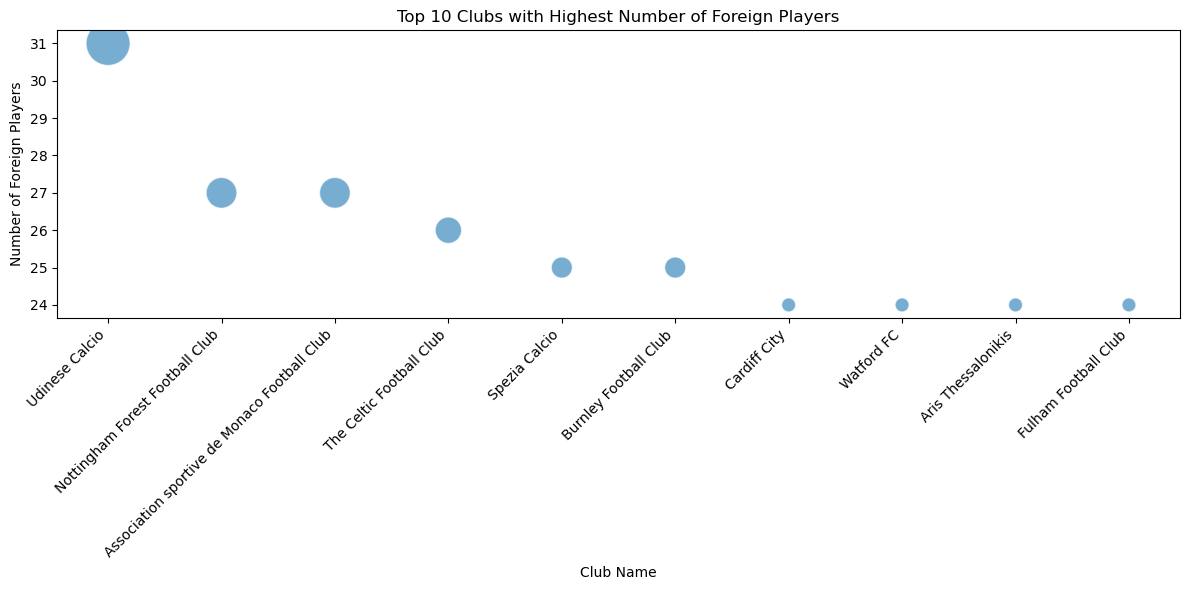

In [26]:
# Top 10 clubs with highest number of foreign players
top_foreign = clubs_df.nlargest(10, 'foreigners_number')

# Create a scatter plot with bubble sizes
plt.figure(figsize=(12, 6))
bubble_sizes = top_foreign['foreigners_number'] * 10  # Scale bubble sizes
sns.scatterplot(data=top_foreign, x='name', y='foreigners_number', size=bubble_sizes, sizes=(100, 1000), legend=False, alpha=0.6)
plt.title('Top 10 Clubs with Highest Number of Foreign Players')
plt.xlabel('Club Name')
plt.ylabel('Number of Foreign Players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

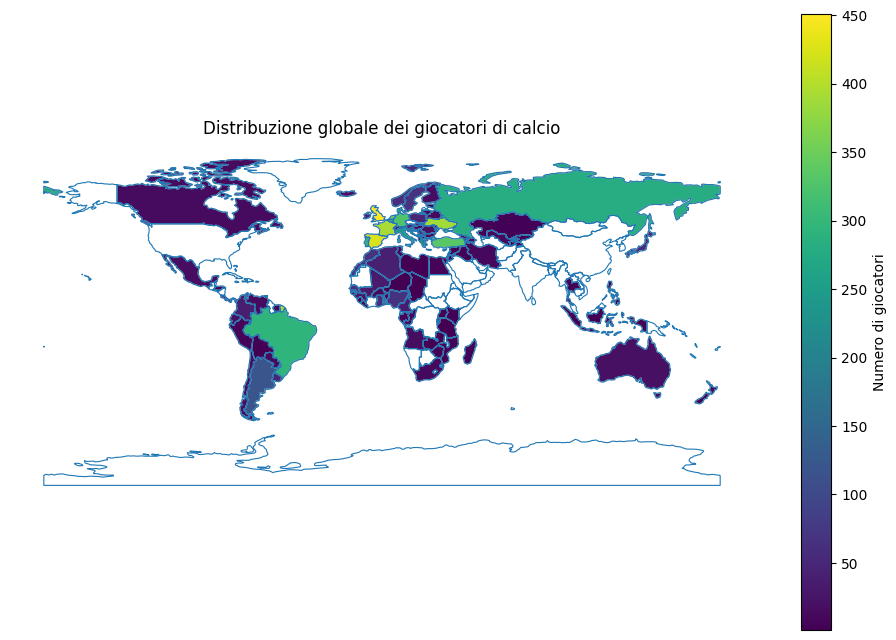

In [89]:
def create_players_map():
    # Calcola il numero di giocatori per ciascuna nazione
    players_count = players_df['country_of_citizenship'].value_counts().reset_index()
    players_count.columns = ['NAME', 'player_count']
    
    # Unisci i dati della mappa con i dati dei giocatori per aggiungere la scala di colori
    birth_countries_geo = world.merge(players_count, on='NAME', how='left')

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))  # Dimensioni della mappa
    world.boundary.plot(ax=ax, linewidth=0.8)  # Disegna i confini dei paesi

    # Plotta i paesi colorati in base al numero di giocatori, utilizzando la scala di colori viridis
    birth_countries_geo.plot(column='player_count', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8',
                             legend=True, legend_kwds={'label': "Numero di giocatori"})
    
    ax.set_axis_off()  # Rimuove le assi x e y
    plt.title('Distribuzione globale dei giocatori di calcio')
    plt.show()

# Chiamata alla funzione per creare la mappa interattiva
create_players_map()

In [20]:
club_player_values = players_df.groupby('current_club_name')['market_value_in_eur'].sum()

# Ordinamento dei club per valore totale dei giocatori in ordine decrescente e prendi i primi 10
top_clubs = club_player_values.sort_values(ascending=False).head(10)

# Seleziona solo i nomi dei primi 10 club
club_list = top_clubs.index.tolist()

# Funzione per calcolare l'età da data di nascita
def calculate_age(born):
    today = pd.Timestamp.now()
    born_date = pd.Timestamp(born)
    age = today.year - born_date.year - ((today.month, today.day) < (born_date.month, born_date.day))
    return age

# Funzione per creare box plot dell'età dei giocatori per un club specifico
def create_age_boxplot(club_name):
    club_players = players_df[players_df['current_club_name'] == club_name].copy()  
    
    # Calcola l'età utilizzando la funzione calculate_age
    club_players['age'] = club_players['date_of_birth'].apply(calculate_age)
    
    # Creazione del box plot dell'età dei giocatori
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='current_club_name', y='age', data=club_players)
    plt.title(f'Distribuzione dell\'età dei giocatori del club {club_name}')
    plt.xticks(rotation=45)
    plt.xlabel('Club')
    plt.ylabel('Età dei giocatori')
    plt.show()

# Creazione del menu a tendina interattivo
if club_list:
    interact(create_age_boxplot, club_name=widgets.Dropdown(
        options=club_list,
        description='Select Club:',
        value=club_list[0]
    ))
else:
    print("Non ci sono club disponibili per visualizzare i dati.")

interactive(children=(Dropdown(description='Select Club:', options=('Manchester City', 'Arsenal FC', 'Paris Sa…

Analisi su quanto incide l'età/esperienza dei giocatori sul numero di goal segnati, si può notare come i giocatori compresi nella fascai d'età trai i 23 e 30 anni siano quelli che segnano più goal. Ciò è dato da un fattore di atletismo ed esperienza.

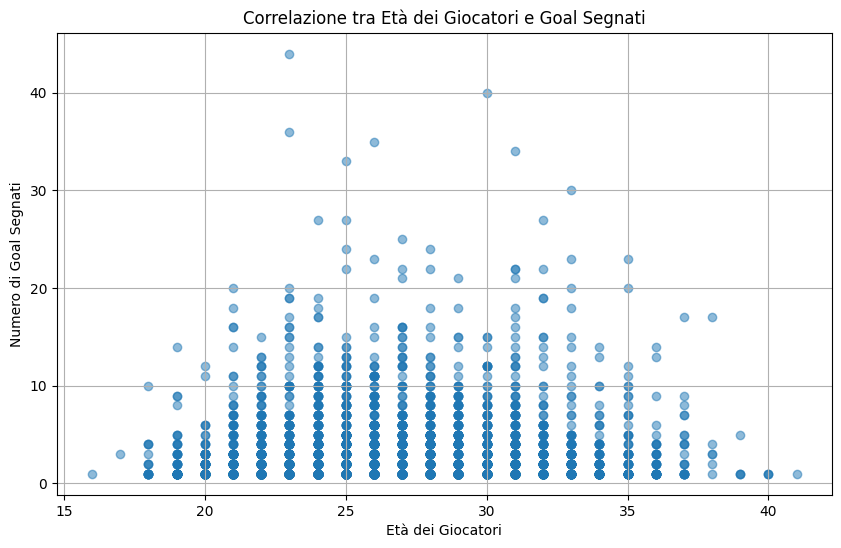

In [91]:
# Definizione della funzione per calcolare l'età
def calculate_age(born):
    today = pd.Timestamp.now()
    born_date = pd.Timestamp(born)
    age = today.year - born_date.year - ((today.month, today.day) < (born_date.month, born_date.day))
    return age

year = 2023
# Unione dei dati dei giocatori con gli eventi di gioco basata sull'ID del giocatore
merged_df = pd.merge(game_events_df, players_df, on='player_id', how='left')

# Pulizia della colonna date_of_birth e calcolo dell'età utilizzando la funzione calculate_age
merged_df['date_of_birth'] = pd.to_datetime(merged_df['date_of_birth'], errors='coerce')
merged_df['age'] = merged_df['date_of_birth'].apply(lambda x: calculate_age(str(x)))
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Filtraggio degli eventi di gioco relativi ai goal per l'anno 2023
goal_events_2023 = merged_df[(merged_df['type'] == 'Goals') & (merged_df['date'].dt.year == 2023)]
# Aggregazione per giocatore per contare i goal segnati e ottenere l'età
goals_per_player = goal_events_2023.groupby('player_id').agg({'type': 'count', 'age': 'first'}).reset_index()
goals_per_player.columns = ['player_id', 'goals_scored', 'age']

# Creazione del grafico di dispersione
plt.figure(figsize=(10, 6))
plt.scatter(goals_per_player['age'], goals_per_player['goals_scored'], alpha=0.5)
plt.title('Correlazione tra Età dei Giocatori e Goal Segnati')
plt.xlabel('Età dei Giocatori')
plt.ylabel('Numero di Goal Segnati')
plt.grid(True)
plt.show()

Analisi sulla provenienza dei 50 giocatori più costosi, per indivduare i paesi che sfornano il maggior numero di campioni

In [6]:
# Seleziona i 50 giocatori più costosi
top_players = players_df.nlargest(50, 'market_value_in_eur')

# Caricamento del dataset di Natural Earth
world = gpd.read_file('../data/naturalearth_lowres/ne_110m_admin_0_countries.shp')

# Calcola il numero di giocatori per ciascuna nazione tra i 50 più costosi
players_count = top_players['country_of_citizenship'].value_counts().reset_index()
players_count.columns = ['NAME', 'player_count']

# Unisci i dati della mappa con i dati dei giocatori per aggiungere la scala di colori
world = world.merge(players_count, on='NAME', how='left')

# Funzione per creare la mappa interattiva
def create_map():
    fig, ax = plt.subplots(figsize=(10, 6))
    world.boundary.plot(ax=ax, linewidth=0.8, color='gray')
    world.plot(column='player_count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
               legend_kwds={'label': "Numero di giocatori", 'orientation': "horizontal"})
    ax.set_axis_off()
    plt.title('Distribuzione geografica dei 50 giocatori più costosi')
    plt.show()

# Creazione del plot interattivo utilizzando ipywidgets
interact(create_map);

interactive(children=(Output(),), _dom_classes=('widget-interact',))

Analisi su come l'età influisca il valore di mercato, si può notare come il fattore di età influisca molto sul valore di mercato, in quanto il potenziale futuro del giocatore è molto importante.

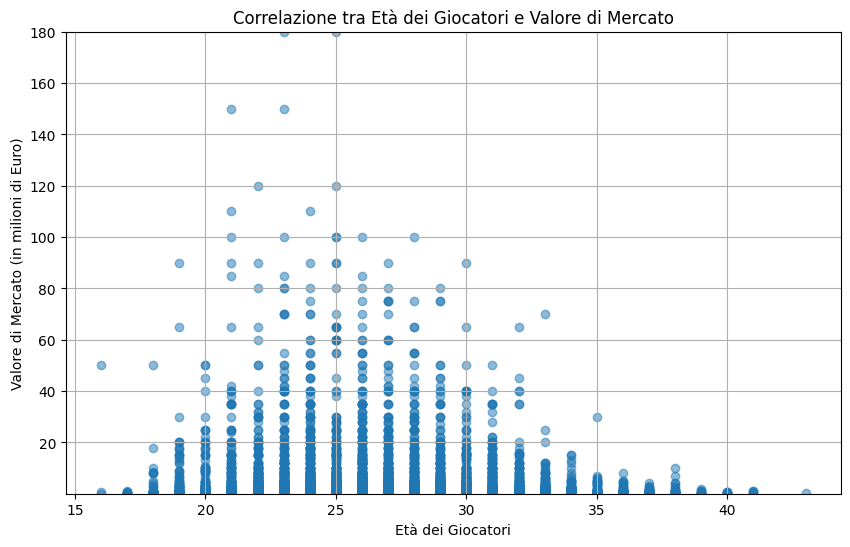

In [93]:
def calculate_age(born):
    today = pd.Timestamp.now()
    born_date = pd.Timestamp(born)
    age = today.year - born_date.year - ((today.month, today.day) < (born_date.month, born_date.day))
    return age

# Pulizia della colonna date_of_birth e calcolo dell'età utilizzando la funzione calculate_age
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'], errors='coerce')
players_df['age'] = players_df['date_of_birth'].apply(lambda x: calculate_age(str(x)))

# Grafico di dispersione per la correlazione tra età e valore di mercato
plt.figure(figsize=(10, 6))
plt.scatter(players_df['age'], players_df['market_value_in_eur']/1000000, alpha=0.5)

plt.title('Correlazione tra Età dei Giocatori e Valore di Mercato')
plt.xlabel('Età dei Giocatori')
plt.ylabel('Valore di Mercato (in milioni di Euro)')
plt.grid(True)

# Formattazione degli assi
plt.ticklabel_format(style='plain', axis='y')  # Mostra i numeri in formato normale invece che scientifico
plt.ylim(players_df['market_value_in_eur'].min()/1000000, players_df['market_value_in_eur'].max()/1000000)

plt.show()

Analisi sui minuti giocati dai giocatori in base all'età, si può notare come nel campionati italiano i giocatori più giovani abbiano giocato molti meno minuti rispetto ai giocatori più esperti, questo denota una sfiducia da parte degli allenatori delle squadre italiane nei confronti dei giovani. Questo argomento è molto discusso in Italia dopo le ultime prestazioni negative della nazionale italiana, dove si è discusso molto sulla scarsa presenza di giovani talenti di nazionalità italiana proprio perchè non giocano molto nei campionati italiani ma devono andare all'estero per giocare.

In [27]:
def upload_plot(competition_id):
    # Merge data on player_id
    merged_df = pd.merge(appearances_df[appearances_df['competition_id'] == competition_id], players_df[players_df['current_club_domestic_competition_id'] == competition_id], on='player_id')

    # Create an age column
    merged_df['age'] = pd.to_datetime('today').year - pd.to_datetime(merged_df['date_of_birth']).dt.year

    # Define age groups
    bins = [15, 20, 25, 30, 35, 40, 45]
    labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45']
    merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels)

    # Create a box plot for minutes played by age group
    plt.figure(figsize=(10, 6))
    merged_df.boxplot(column='minutes_played', by='age_group', grid=False)
    plt.title('Minutes Played by Age Group')
    plt.suptitle('')
    plt.xlabel('Age Group')
    plt.ylabel('Minutes Played')
    plt.xticks(rotation=45)
    plt.show()

# Create a list of tuples for the Dropdown options
options = [(row['name'], row['competition_id']) for index, row in competitions_df[competitions_df['type'] == 'domestic_league'].iterrows()]

# Widget Dropdown to select competition_id
dropdown = widgets.Dropdown(options=options, description="Competition:")
widgets.interactive(upload_plot, competition_id=dropdown)

interactive(children=(Dropdown(description='Competition:', options=(('superligaen', 'DK1'), ('laliga', 'ES1'),…

Analisi della distribuzione dell'altezza dei giocatori per i primi 10 club per valore totale di mercato. Il fattore altezza dipende anche molto dallo stile di gioco della squadra, ad esempio squadre che giocano molto sulle palle alte tendono ad avere giocatori più alti.

In [7]:
# Raggruppamento dei club per valore totale dei giocatori in ordine decrescente e prendi i primi 10
club_player_values = players_df.groupby('current_club_name')['market_value_in_eur'].sum()
top_clubs = club_player_values.sort_values(ascending=False).head(10)
club_list = top_clubs.index.tolist()

# Funzione per creare box plot dell'altezza dei giocatori per un club specifico
def create_height_boxplot(club_name):
    club_players = players_df[players_df['current_club_name'] == club_name].copy()  
    
    # Creazione del box plot dell'altezza dei giocatori
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='current_club_name', y='height_in_cm', data=club_players)
    plt.title(f'Distribuzione dell\'altezza dei giocatori del club {club_name}')
    plt.xticks(rotation=45)
    plt.xlabel('Club')
    plt.ylabel('Altezza dei giocatori (cm)')
    plt.show()

# Creazione del menu a tendina interattivo
if club_list:
    interact(create_height_boxplot, club_name=widgets.Dropdown(
        options=club_list,
        description='Select Club:',
        value=club_list[0]
    ))
else:
    print("Non ci sono club disponibili per visualizzare i dati.")


interactive(children=(Dropdown(description='Select Club:', options=('Manchester City', 'Arsenal FC', 'Paris Sa…

# Analisi sugli eventi

In [25]:
# Unire i dati dei game_events con i dati dei club
game_events = game_events_df.merge(clubs_df[['club_id', 'name']], on='club_id', how='left')

# Filtrare gli eventi di tipo "Cards"
cards = game_events[game_events['type'] == 'Cards']

# Aggiungere una colonna per il tipo di cartellino
cards.loc[:, 'card_type'] = cards['description'].apply(lambda x: 'Yellow' if 'Yellow' in x else 'Red' if 'Red' in x or 'Second Yellow' in x else 'Unknown')

# Lista dei club
club_list = cards['name'].unique().tolist()

# Funzione per creare il violin plot dei cartellini per un club specifico
def create_card_violin_plot(club_name):
    club_cards = cards[(cards['name'] == club_name) & (cards['card_type'] != 'Unknown')]
    
    # Creare il violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='card_type', y='minute', data=club_cards, scale='width', inner='quartile')
    plt.title(f'Distribuzione dei cartellini per minuti - {club_name}')
    plt.xlabel('Tipo di cartellino')
    plt.ylabel('Minuti')
    plt.show()

# Creazione del menu a tendina interattivo
if club_list:
    interact(create_card_violin_plot, club_name=widgets.Dropdown(
        options=club_list,
        description='Select Club:',
        value=club_list[0]
    ))
else:
    print("Non ci sono club disponibili per visualizzare i dati.")


/var/folders/fh/s4mnrx2502z7lc00pv78vsc00000gn/T/ipykernel_1867/3548465524.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cards.loc[:, 'card_type'] = cards['description'].apply(lambda x: 'Yellow' if 'Yellow' in x else 'Red' if 'Red' in x or 'Second Yellow' in x else 'Unknown')


interactive(children=(Dropdown(description='Select Club:', options=('AFC Ajax Amsterdam', 'Eindhovense Voetbal…

Analisi su quali ruoli sono più propensi a prender ecartellini gialli

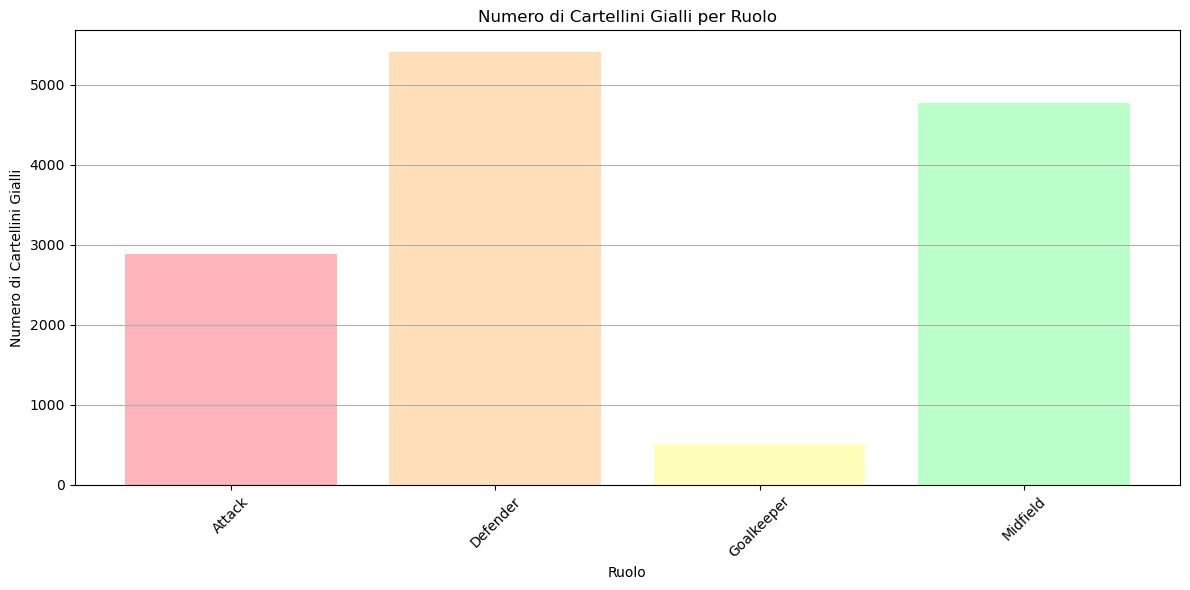

In [31]:
# Unione dei dati dei giocatori con gli eventi di gioco basata sull'ID del giocatore
merged_df = pd.merge(game_events_df, players_df, on='player_id', how='left')

# Filtraggio degli eventi di gioco relativi ai cartellini gialli (codificati come "Cards" e con "yellow card" nella descrizione)
yellow_card_events = merged_df[(merged_df['type'] == 'Cards') & (merged_df['description'].str.contains('yellow card', case=False, na=False))]

# Aggregazione per giocatore per contare i cartellini gialli presi e ottenere il ruolo
yellow_cards_per_player = yellow_card_events.groupby('player_id').agg({'type': 'count', 'position': 'first'}).reset_index()
yellow_cards_per_player.columns = ['player_id', 'yellow_cards', 'position']

# Rimozione delle righe con valori mancanti nella colonna 'position'
yellow_cards_per_player = yellow_cards_per_player.dropna(subset=['position'])

# Mappatura delle categorie desiderate
desired_positions = ['Goalkeeper', 'Defender', 'Midfield', 'Attack']
yellow_cards_per_player = yellow_cards_per_player[yellow_cards_per_player['position'].isin(desired_positions)]

# Aggregazione per ruolo per contare i cartellini gialli presi
yellow_cards_per_position = yellow_cards_per_player.groupby('position').agg({'yellow_cards': 'sum'}).reset_index()

# Creazione del grafico a barre
plt.figure(figsize=(12, 6))
plt.bar(yellow_cards_per_position['position'], yellow_cards_per_position['yellow_cards'], color=custom_colors)
plt.title('Numero di Cartellini Gialli per Ruolo')
plt.xlabel('Ruolo')
plt.ylabel('Numero di Cartellini Gialli')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Mostra il grafico
plt.tight_layout()
plt.show()

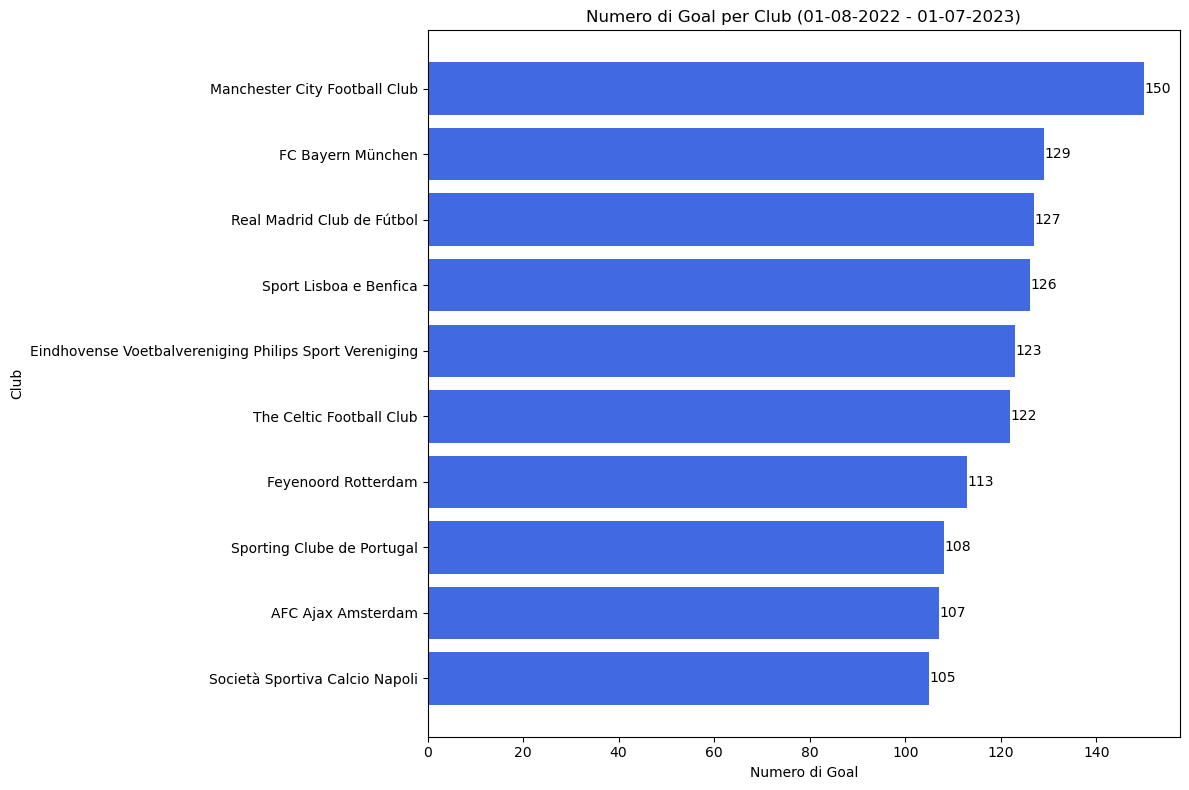

In [28]:
# Convertire la colonna delle date in formato datetime
game_events_df['date'] = pd.to_datetime(game_events_df['date'])

# Filtrare gli eventi di goal e le date richieste
goal_events_df = game_events_df[(game_events_df['type'] == 'Goals') &
                           (game_events_df['date'] >= '2022-08-01') &
                           (game_events_df['date'] <= '2023-07-01')]

# Contare il numero di goal per club
goals_per_club = goal_events_df['club_id'].value_counts().reset_index()
goals_per_club.columns = ['club_id', 'num_goals']

# Unire i dati con le informazioni dei club
merged_df = pd.merge(goals_per_club, clubs_df, on='club_id')

# Ordinare i dati per una migliore visualizzazione e selezionare i primi 10 club
top_10_clubs = merged_df.sort_values(by='num_goals', ascending=False).head(10)

# Creare il grafico
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_clubs['name'], top_10_clubs['num_goals'], color='royalblue')
plt.xlabel('Numero di Goal')
plt.ylabel('Club')
plt.title('Numero di Goal per Club (01-08-2022 - 01-07-2023)')
plt.gca().invert_yaxis()  # Invertire l'asse y per avere il club con più goal in cima

# Aggiungere il numero di goal accanto alle barre
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
             f'{width}', va='center', ha='left')

# Aggiungere spaziatura tra i nomi dei club
plt.tight_layout()

plt.show()

Analisi per verificare quanto incide il valore di mercato dei giocatori sul numero di goal segnati dai club, si può notare come i club con più valore di mercato abbiano segnato più goal, questo è dovuto al fatto che i giocatori più costosi sono anche i più forti e quindi segnano più goal.

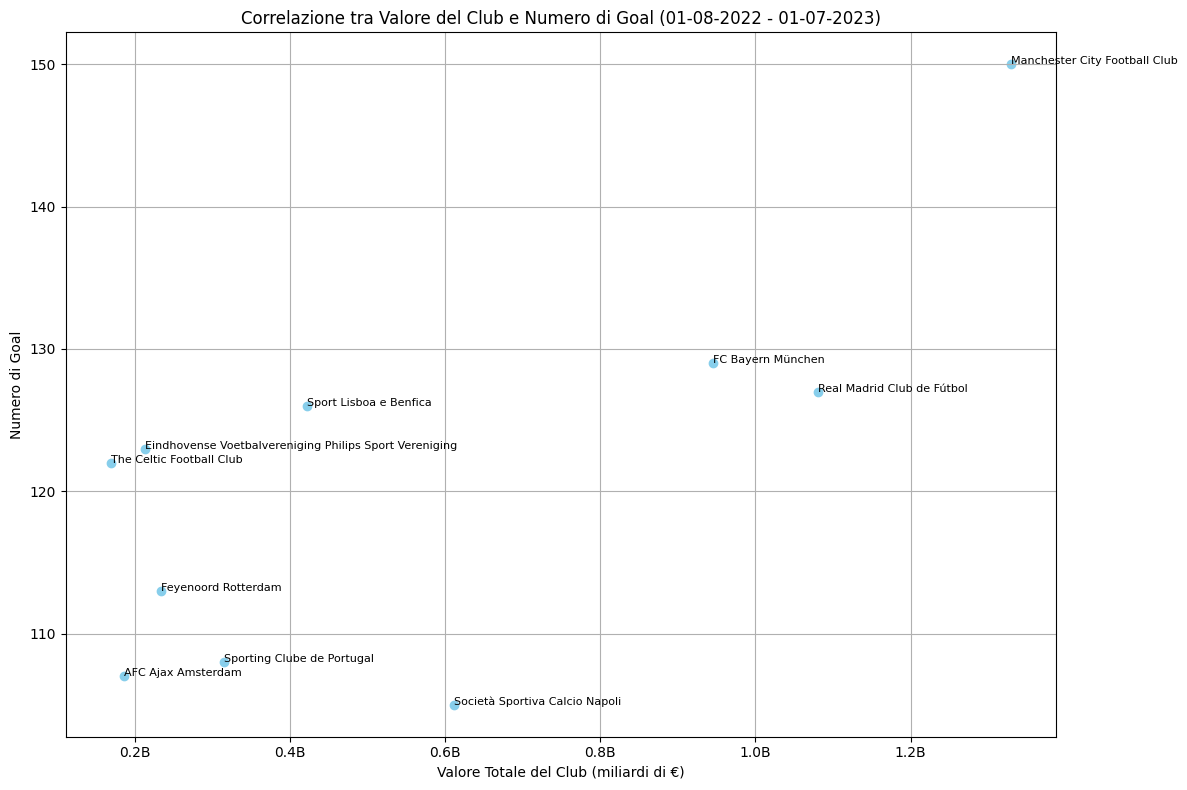

In [123]:
# Convertire la colonna delle date in formato datetime
game_events_df['date'] = pd.to_datetime(game_events_df['date'])

# Filtrare gli eventi di goal e le date richieste
goal_events_df = game_events_df[(game_events_df['type'] == 'Goals') &
                           (game_events_df['date'] >= '2022-08-01') &
                           (game_events_df['date'] <= '2023-07-01')]

# Contare il numero di goal per club
goals_per_club = goal_events_df['club_id'].value_counts().reset_index()
goals_per_club.columns = ['club_id', 'num_goals']

# Unire i dati con le informazioni dei club
merged_clubs_df = pd.merge(goals_per_club, clubs_df, on='club_id')

# Ordinare i dati e selezionare i primi 10 club con più goal
top_10_clubs = merged_clubs_df.sort_values(by='num_goals', ascending=False).head(10)

# Calcolare il valore totale dei giocatori per ciascun club (in miliardi di €)
club_player_values = players_df.groupby('current_club_id')['market_value_in_eur'].sum().reset_index()
club_player_values.columns = ['club_id', 'total_market_value']
club_player_values['total_market_value'] /= 1e9  # Convertire in miliardi di €

# Unire i dati dei goal con i dati dei valori dei club utilizzando gli ID dei club
final_df = pd.merge(top_10_clubs, club_player_values, on='club_id')

# Aggiungere il nome del club come colonna per il grafico
final_df['club_name'] = final_df['name']

# Creare il grafico di correlazione
plt.figure(figsize=(12, 8))
plt.scatter(final_df['total_market_value'], final_df['num_goals'], color='skyblue')
plt.xlabel('Valore Totale del Club (miliardi di €)')
plt.ylabel('Numero di Goal')
plt.title('Correlazione tra Valore del Club e Numero di Goal (01-08-2022 - 01-07-2023)')

# Aggiungere le etichette dei club ai punti
for i, row in final_df.iterrows():
    plt.text(row['total_market_value'], row['num_goals'], row['club_name'], fontsize=8)

# Formattare l'asse x per mostrare i valori in miliardi
formatter = FuncFormatter(lambda x, _: f'{x:.1f}B')
plt.gca().xaxis.set_major_formatter(formatter)

plt.grid(True)
plt.tight_layout()
plt.show()

# Analisi sulla correlazione tra differenza reti e posizione in classifica
Un noto allenatore quale Max Allegri ha sempre detto che il fattore che incide di più per vincere i campionati non è tanto il possesso palla, il gioco propositivo(offensivo), ma la differenza reti. Con la differenza reti si vincono i campionati e questa analisi lo dimostra.

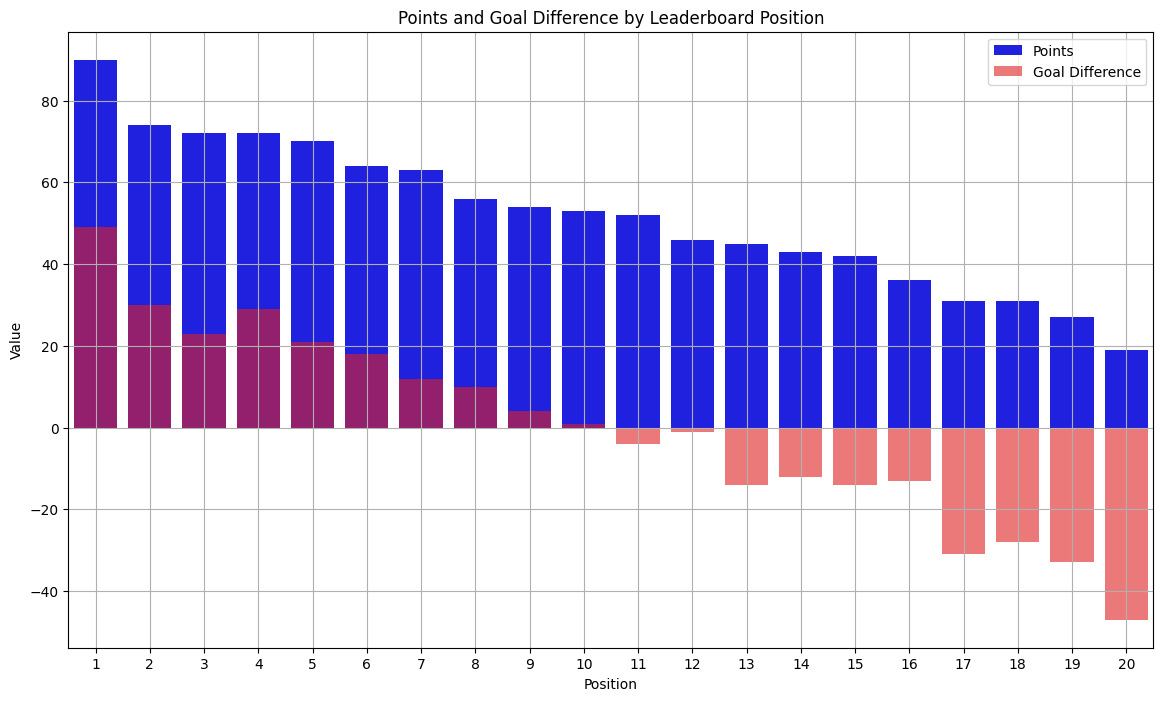

In [115]:
# Filter the data for competition_id 'IT1' and season '2022'
filtered_games = games_df[(games_df['competition_id'] == 'IT1') & (games_df['season'] == 2022)]

# Initialize a dictionary to store the points for each club
points = {}

# Iterate through the filtered games and calculate points
for index, row in filtered_games.iterrows():
    home_club = row['home_club_id']
    away_club = row['away_club_id']
    home_goals = row['home_club_goals']
    away_goals = row['away_club_goals']

    if home_club not in points:
        points[home_club] = 0
    if away_club not in points:
        points[away_club] = 0

    if home_goals > away_goals:
        points[home_club] += 3
    elif home_goals < away_goals:
        points[away_club] += 3
    else:
        points[home_club] += 1
        points[away_club] += 1

# Convert the points dictionary to a DataFrame
leaderboard_df = pd.DataFrame(list(points.items()), columns=['club_id', 'points'])

# Sort the leaderboard by points in descending order
leaderboard_df = leaderboard_df.sort_values(by='points', ascending=False).reset_index(drop=True)

# Merge the leaderboard with the clubs dataframe to get the club names
leaderboard_with_names = leaderboard_df.merge(clubs_df[['club_id', 'name']], on='club_id', how='left')

# Reorder the columns to have the club name first
leaderboard_with_names = leaderboard_with_names[['name', 'points', 'club_id']]

# Calculate the goal difference for each club in the filtered games
goal_diff = {}

for index, row in filtered_games.iterrows():
    home_club = row['home_club_id']
    away_club = row['away_club_id']
    home_goals = row['home_club_goals']
    away_goals = row['away_club_goals']

    if home_club not in goal_diff:
        goal_diff[home_club] = 0
    if away_club not in goal_diff:
        goal_diff[away_club] = 0

    goal_diff[home_club] += (home_goals - away_goals)
    goal_diff[away_club] += (away_goals - home_goals)

# Convert the goal_diff dictionary to a DataFrame
goal_diff_df = pd.DataFrame(list(goal_diff.items()), columns=['club_id', 'goal_difference'])

# Merge the goal difference with the leaderboard
goal_diff_leaderboard = leaderboard_with_names.merge(goal_diff_df, on='club_id', how='left')

# Add a position column to the leaderboard
goal_diff_leaderboard['position'] = goal_diff_leaderboard.index + 1

# Calculate the correlation between position and goal difference
correlation = goal_diff_leaderboard['position'].corr(goal_diff_leaderboard['goal_difference'])
# Plot the double columns bar chart with points and goal difference based on the leaderboard position
plt.figure(figsize=(14, 8))

# Bar plot for points
sns.barplot(x='position', y='points', data=goal_diff_leaderboard, color='blue', label='Points')

# Bar plot for goal difference
sns.barplot(x='position', y='goal_difference', data=goal_diff_leaderboard, color='red', label='Goal Difference', alpha=0.6)

plt.title('Points and Goal Difference by Leaderboard Position')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

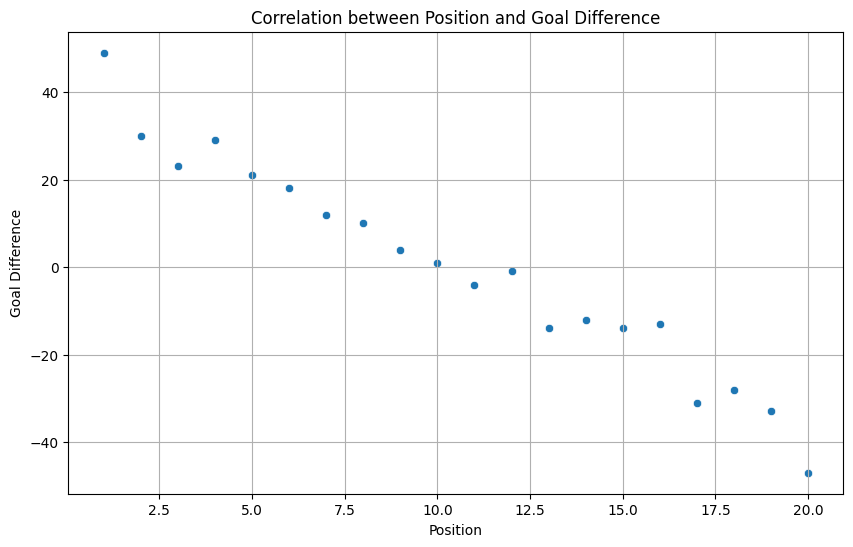

In [102]:
# Plot the correlation between position and goal difference
plt.figure(figsize=(10, 6))
sns.scatterplot(x='position', y='goal_difference', data=goal_diff_leaderboard)
plt.title('Correlation between Position and Goal Difference')
plt.xlabel('Position')
plt.ylabel('Goal Difference')
plt.grid(True)
plt.show()

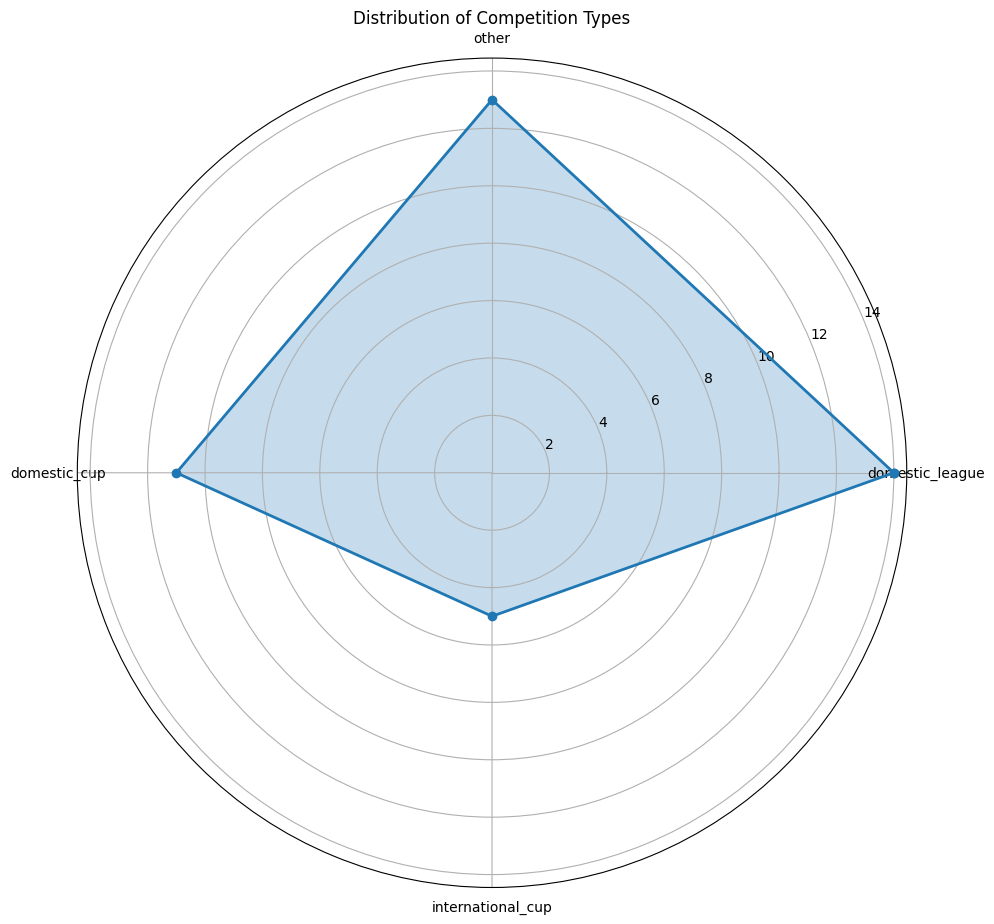

In [104]:
# Compass (Radar) Chart for competition types
plt.figure(figsize=(10, 10))
types = competitions_df['type'].value_counts()
angles = [n / float(len(types)) * 2 * 3.141593 for n in range(len(types))]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
ax.plot(angles, types.values.tolist() + [types.values.tolist()[0]], 'o-', linewidth=2)
ax.fill(angles, types.values.tolist() + [types.values.tolist()[0]], alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(types.index)
ax.set_title('Distribution of Competition Types')
plt.tight_layout()


# Analisi riguardante gli arbitri
Media dei cartellini dati per partita dei 10 arbitri con media cartellini più alta(più severi) 
(arbitri con almeno 10 partite aribitrate)

<Figure size 1200x600 with 0 Axes>

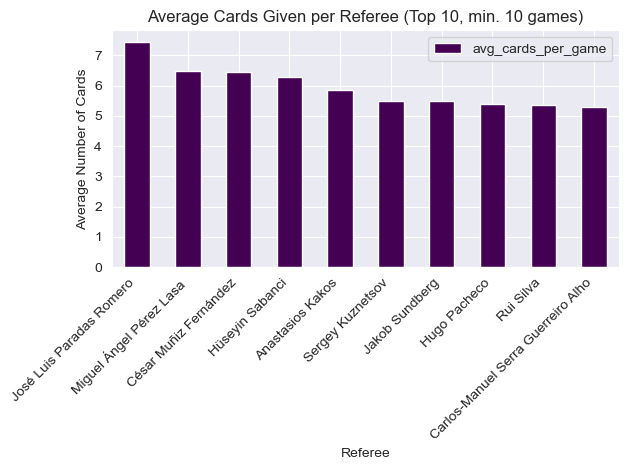

In [15]:
# Filter card events
card_events = game_events_df[game_events_df['type'] == 'Cards']

# Count cards per game
cards_per_game = card_events.groupby('game_id').size().reset_index(name='card_count')

# Merge with games dataframe
games_with_cards = pd.merge(games_df, cards_per_game, on='game_id', how='left')
games_with_cards['card_count'] = games_with_cards['card_count'].fillna(0)

# Calculate referee statistics
referee_stats = games_with_cards.groupby('referee').agg({
    'game_id': 'count',
    'card_count': 'sum'
}).reset_index()
referee_stats.columns = ['referee', 'total_games', 'total_cards']
referee_stats['avg_cards_per_game'] = referee_stats['total_cards'] / referee_stats['total_games']

# Filter referees with at least 10 games
experienced_referees = referee_stats[referee_stats['total_games'] >= 10].sort_values('avg_cards_per_game', ascending=False)

# Plot average cards per referee (top 20 experienced referees)
plt.figure(figsize=(12, 6))
experienced_referees.head(10).plot(x='referee', y='avg_cards_per_game', kind='bar', cmap="viridis")
plt.title('Average Cards Given per Referee (Top 10, min. 10 games)')
plt.xlabel('Referee')
plt.ylabel('Average Number of Cards')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Scatter plot per visualizzare tutti gli arbitri con almeno 10 partite e confrontare il numero totale di partite e il numero totale di cartellini dati.

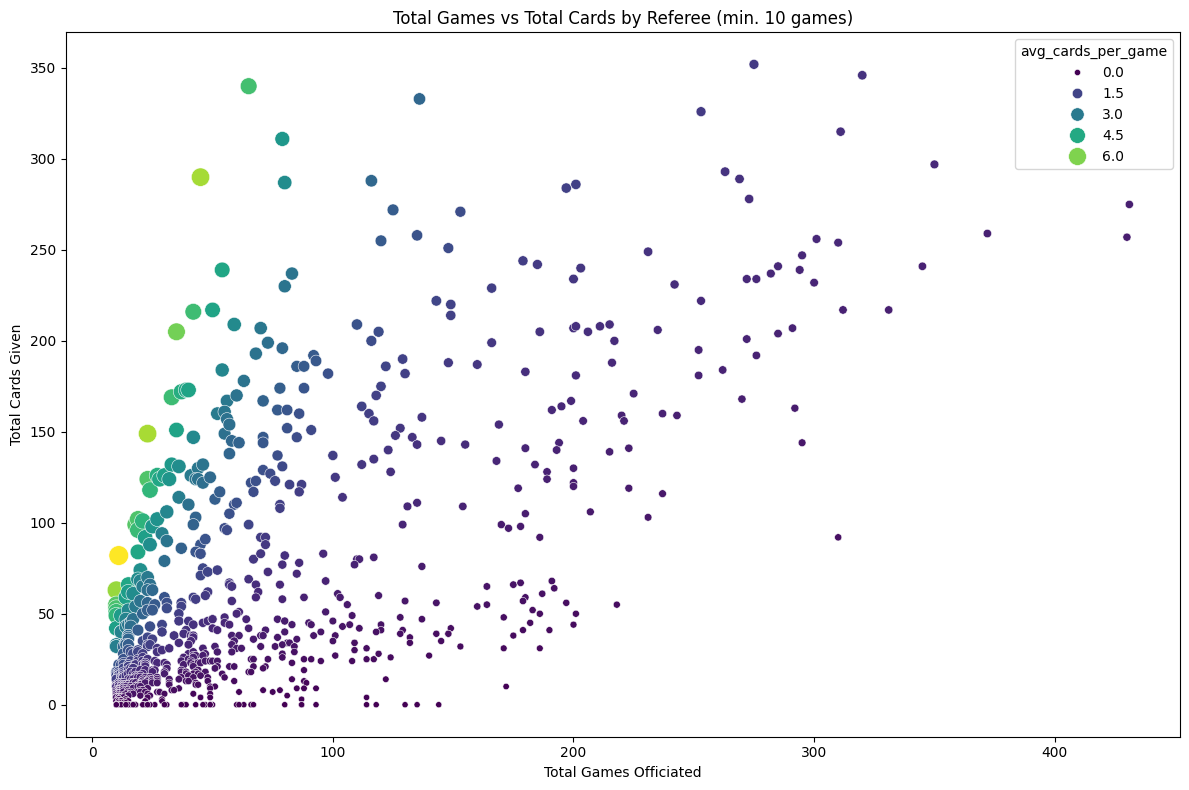

In [106]:
# Plot scatter plot of total games vs total cards for experienced referees
plt.figure(figsize=(12, 8))
sns.scatterplot(data=experienced_referees, x='total_games', y='total_cards', hue='avg_cards_per_game', size='avg_cards_per_game', sizes=(20, 200), palette='viridis')
plt.title('Total Games vs Total Cards by Referee (min. 10 games)')
plt.xlabel('Total Games Officiated')
plt.ylabel('Total Cards Given')
plt.tight_layout()
plt.show()


Analisi sull'andamento del mercato, attraverso il calcolo del costo medio dei top 15 giocatori per ogni anno. Si può notare come il mercato sia sceso durante il periodo del COVID-19.

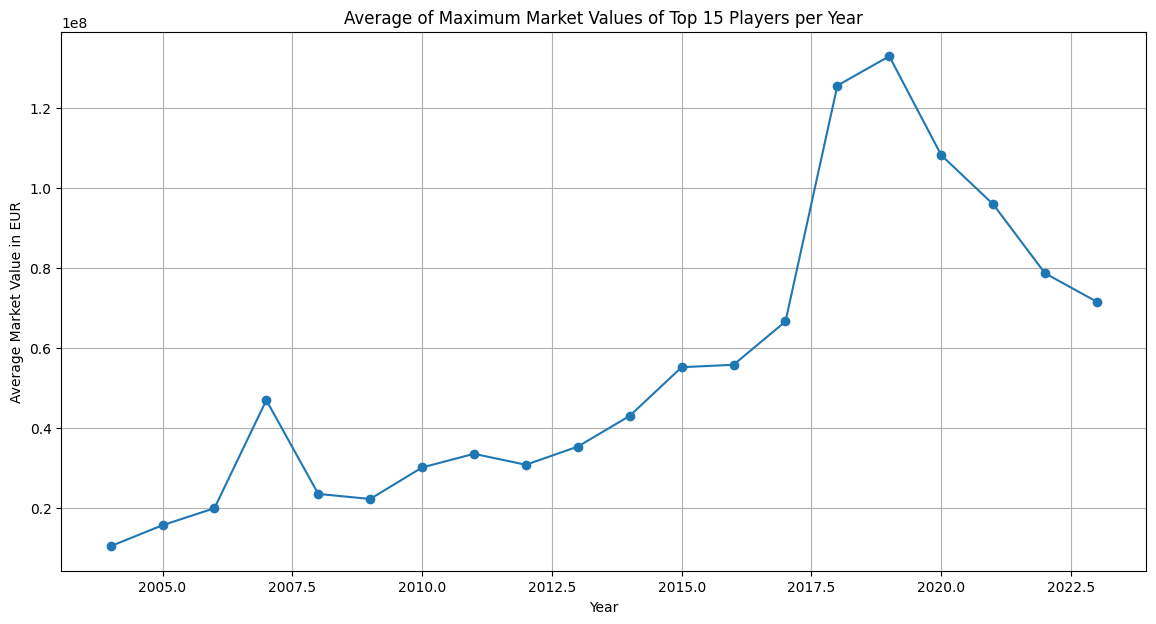

In [108]:
# Convert date to datetime and extract year
player_valuations_df['date'] = pd.to_datetime(player_valuations_df['date'])
player_valuations_df['year'] = player_valuations_df['date'].dt.year

# Filter for the top 15 players by maximum market value
top_players = player_valuations_df.groupby('player_id')['market_value_in_eur'].max().nlargest(15).index
df_top_players = player_valuations_df[player_valuations_df['player_id'].isin(top_players)]

# Get the maximum market value per player per year
df_max_per_year = df_top_players.groupby(['player_id', 'year'])['market_value_in_eur'].max().reset_index()

# Calculate the average of these maximum values per year
df_yearly_avg = df_max_per_year.groupby('year')['market_value_in_eur'].mean().reset_index()


plt.figure(figsize=(14, 7))
plt.plot(df_yearly_avg['year'], df_yearly_avg['market_value_in_eur'], marker='o')
plt.title('Average of Maximum Market Values of Top 15 Players per Year')
plt.xlabel('Year')
plt.ylabel('Average Market Value in EUR')
plt.grid(True)
plt.show()

In [18]:

def upload_plot(club_id):
    players_per_position = players_df[players_df['current_club_id'] == club_id].groupby('position').size().reset_index(name='frequency')
    players_per_position.columns = ['position', 'frequency']
    
    positions = players_per_position['position']
    frequencies = players_per_position['frequency']
    
    angles = np.linspace(0, 2 * np.pi, len(positions), endpoint=False).tolist()
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    bars = ax.bar(angles, frequencies, width=0.7, bottom=0.1, color='green', alpha=0.75)
    
    ax.set_xticks(angles)
    ax.set_xticklabels(positions)
    ax.set_title('Distribution of club\'s players\' positions', va='bottom')
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_yticklabels([str(int(x)) for x in ax.get_yticks()])
    
    plt.show()

filtered_clubs = clubs_df[clubs_df['domestic_competition_id'] == 'IT1']

# Ordina i club filtrati e prendi i primi 20
top_club_ids = filtered_clubs.sort_values(by='domestic_competition_id', ascending=False).head(20).index


# Fetch club names and IDs
clubs_info = clubs_df.loc[top_club_ids, ['club_id', 'name']]
# Create a list of tuples for the Dropdown options
options = [(row['name'], row['club_id']) for index, row in clubs_info.iterrows()]

# Widget Dropdown to select club_id
dropdown = widgets.Dropdown(options=options, description="Club:")
widgets.interactive(upload_plot, club_id=dropdown)

interactive(children=(Dropdown(description='Club:', options=(('Associazione Sportiva Roma', 12), ('Cagliari Ca…

In [17]:
def update_plot(player_id):
    player_events = game_events_df[game_events_df['player_id'] == player_id]
    type_counts = player_events['type'].value_counts().reset_index()
    type_counts.columns = ['type', 'counts']
    
    labels = type_counts['type']
    num_vars = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    values = type_counts['counts'].tolist()
    
    values += values[:1]
    angles += angles[:1]
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='green', alpha=0.25)
    ax.plot(angles, values, color='green')  # Line
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    plt.show()

player_event_matches = game_events_df['player_id'].value_counts().head(50)
top_player_ids = player_event_matches.index

# Fetch player names and IDs
players_info = players_df[players_df['player_id'].isin(top_player_ids)][['player_id', 'name']]

# Create a list of tuples for the Dropdown options
options = [(row['name'], row['player_id']) for index, row in players_info.iterrows()]

# Widget Dropdown to select player_id
dropdown = widgets.Dropdown(options=options, description="Player:")
widgets.interactive(update_plot, player_id=dropdown)

interactive(children=(Dropdown(description='Player:', options=(('Ángel Di María', 45320), ('Pedro', 65278), ('…